In [1]:
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Minimal script for reproducing the figures of the StyleGAN paper using pre-trained generators."""
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import os
import pickle
import random
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import ipywidgets as widgets
from tqdm import tqdm
#----------------------------------------------------------------------------
# Helpers for loading and using pre-trained generators.

url_ffhq        = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
url_celebahq    = 'https://drive.google.com/uc?id=1MGqJl28pN4t7SAtSrPdSRJSQJqahkzUf' # karras2019stylegan-celebahq-1024x1024.pkl
url_bedrooms    = 'https://drive.google.com/uc?id=1MOSKeGF0FJcivpBI7s63V9YHloUTORiF' # karras2019stylegan-bedrooms-256x256.pkl
url_cars        = 'https://drive.google.com/uc?id=1MJ6iCfNtMIRicihwRorsM3b7mmtmK9c3' # karras2019stylegan-cars-512x384.pkl
url_cats        = 'https://drive.google.com/uc?id=1MQywl0FNt6lHu8E_EUqnRbviagS7fbiJ' # karras2019stylegan-cats-256x256.pkl

synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

_Gs_cache = dict()

def load_Gs(url):
    if url not in _Gs_cache:
        with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
            _G, _D, Gs = pickle.load(f)
        _Gs_cache[url] = Gs
    return _Gs_cache[url]


def draw_uncurated_result_figure(png, Gs, cx, cy, cw, ch, rows, lods, seed):
    latents = np.random.RandomState(seed).randn(sum(rows * 2**lod for lod in lods), Gs.input_shape[1])
    images = Gs.run(latents, None, **synthesis_kwargs) # [seed, y, x, rgb]

    canvas = PIL.Image.new('RGB', (sum(cw // 2**lod for lod in lods), ch * rows), 'white')
    image_iter = iter(list(images))
    for col, lod in enumerate(lods):
        for row in range(rows * 2**lod):
            image = PIL.Image.fromarray(next(image_iter), 'RGB')
            image = image.crop((cx, cy, cx + cw, cy + ch))
            image = image.resize((cw // 2**lod, ch // 2**lod), PIL.Image.ANTIALIAS)
            canvas.paste(image, (sum(cw // 2**lod for lod in lods[:col]), row * ch // 2**lod))
    return canvas


def draw_style_mixing_figure(png, Gs, w, h, src_seeds, dst_seeds, style_ranges):
    src_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in src_seeds)
    dst_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in dst_seeds)
    src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_seeds)), h * (len(dst_seeds))), 'white')
    #for col, src_image in enumerate(list(src_images)):
    for row, dst_image in enumerate(list(dst_images)):
        #canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_seeds))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col) * w, (row) * h))
    return canvas



def draw_noise_detail_figure(png, Gs, w, h, num_samples, seeds):
    canvas = PIL.Image.new('RGB', (w * 3, h * len(seeds)), 'white')
    for row, seed in enumerate(seeds):
        latents = np.stack([np.random.RandomState(seed).randn(Gs.input_shape[1])] * num_samples)
        images = Gs.run(latents, None, truncation_psi=1, **synthesis_kwargs)
        canvas.paste(PIL.Image.fromarray(images[0], 'RGB'), (0, row * h))
        for i in range(4):
            crop = PIL.Image.fromarray(images[i + 1], 'RGB')
            crop = crop.crop((650, 180, 906, 436))
            crop = crop.resize((w//2, h//2), PIL.Image.NEAREST)
            canvas.paste(crop, (w + (i%2) * w//2, row * h + (i//2) * h//2))
        diff = np.std(np.mean(images, axis=3), axis=0) * 4
        diff = np.clip(diff + 0.5, 0, 255).astype(np.uint8)
        canvas.paste(PIL.Image.fromarray(diff, 'L'), (w * 2, row * h))
    return canvas

def draw_noise_components_figure(png, Gs, w, h, seeds, noise_ranges, flips):
    Gsc = Gs.clone()
    noise_vars = [var for name, var in Gsc.components.synthesis.vars.items() if name.startswith('noise')]
    noise_pairs = list(zip(noise_vars, tflib.run(noise_vars))) # [(var, val), ...]
    latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in seeds)
    all_images = []
    for noise_range in noise_ranges:
        tflib.set_vars({var: val * (1 if i in noise_range else 0) for i, (var, val) in enumerate(noise_pairs)})
        range_images = Gsc.run(latents, None, truncation_psi=1, randomize_noise=False, **synthesis_kwargs)
        range_images[flips, :, :] = range_images[flips, :, ::-1]
        all_images.append(list(range_images))

    canvas = PIL.Image.new('RGB', (w * 2, h * 2), 'white')
    for col, col_images in enumerate(zip(*all_images)):
        canvas.paste(PIL.Image.fromarray(col_images[0], 'RGB').crop((0, 0, w//2, h)), (col * w, 0))
        canvas.paste(PIL.Image.fromarray(col_images[1], 'RGB').crop((w//2, 0, w, h)), (col * w + w//2, 0))
        canvas.paste(PIL.Image.fromarray(col_images[2], 'RGB').crop((0, 0, w//2, h)), (col * w, h))
        canvas.paste(PIL.Image.fromarray(col_images[3], 'RGB').crop((w//2, 0, w, h)), (col * w + w//2, h))
    return canvas

def draw_image(seed,Gs):
    latents = np.random.RandomState(seed).randn(1,Gs.input_shape[1])
    dlatents = np.stack(Gs.components.mapping.run(latents, None)) # [seed, layer, component]
    canvas = PIL.Image.fromarray(Gs.components.synthesis.run(dlatents, randomize_noise=True, **synthesis_kwargs)[0],'RGB',format='jpg')
    return canvas.resize((256,256))

def draw_truncation_trick_figure(png, Gs, w, h, seeds, psis):
    latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in seeds)
    dlatents = Gs.components.mapping.run(latents, None) # [seed, layer, component]
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    canvas = PIL.Image.new('RGB', (w * len(psis), h * len(seeds)), 'white')
    for row, dlatent in enumerate(list(dlatents)):
        row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(psis, [-1, 1, 1]) + dlatent_avg
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), (col * w, row * h))
    return canvas

def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        PIL.Image.fromarray(images[idx], 'RGB').save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s.mp4' % (temp_dir,  out_name)
    print(cmd)
    os.system(cmd)
    os.system('del /S %s'%temp_dir)

def generate_image(latent_vector, Gs):
    latent_vector = latent_vector.reshape((1, 18, 512))
    img_array = Gs.components.synthesis.run(latent_vector, randomize_noise=False, **synthesis_kwargs)[0]
    return img_array  

def move_and_show(latent_vector, Gs, direction, frames, rangestart, rangeend):
    step = (rangeend - rangestart) / frames
    output = []
    for i in range(0,frames):
        coeff = rangestart + ( step * i )
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:18] = (latent_vector + coeff*direction)[:18]
        output.append(generate_image(new_latent_vector, Gs))
    return output



def draw_image_from_dlatents(dlatents,Gs):
    dlatents_new = latents.reshape((1, 18, 512))
    canvas = PIL.Image.fromarray(Gs.components.synthesis.run(dlatents_new, randomize_noise=True, **synthesis_kwargs)[0],'RGB')
    return canvas

    
def draw_image_from_latents(latents,Gs):
    dlatents = latents.reshape((1, 18, 512))
    canvas = PIL.Image.fromarray(Gs.components.synthesis.run(dlatents, randomize_noise=False, **synthesis_kwargs)[0],'RGB')
    return canvas

gender_direction = np.load('trained_directions/gender_direction.npy')
headPose_yaw_direction = np.load('trained_directions/headPose_yaw_direction.npy')
headPose_roll_direction = np.load('trained_directions/headPose_roll_direction.npy')
#headPose_pitch_direction = np.load('trained_directions/headPose_pitch_direction.npy')  # no headPose_pitch data in training dataset
age_kid_direction = np.load('trained_directions/age_young_direction.npy')
age_middle_direction = np.load('trained_directions/age_middle_direction.npy')
age_young_direction = np.load('trained_directions/age_young_direction.npy')
age_old_direction = np.load('trained_directions/age_old_direction.npy')
glasses_direction = np.load('trained_directions/glasses_direction.npy')
smile_direction = np.load('trained_directions/smile_direction.npy')
anger_direction = np.load('trained_directions/anger_direction.npy')
sadness_direction = np.load('trained_directions/sadness_direction.npy')
contempt_direction = np.load('trained_directions/contempt_direction.npy')
disgust_direction = np.load('trained_directions/disgust_direction.npy')
fear_direction = np.load('trained_directions/fear_direction.npy')
happiness_direction = np.load('trained_directions/happiness_direction.npy')
neutral_direction = np.load('trained_directions/neutral_direction.npy')
surprise_direction = np.load('trained_directions/surprise_direction.npy')
eyeMakeup_direction = np.load('trained_directions/eyeMakeup_direction.npy')
lipMakeup_direction = np.load('trained_directions/lipMakeup_direction.npy')
beard_direction = np.load('trained_directions/beard_direction.npy')
facialhair_direction = np.load('trained_directions/facialhair_direction.npy')
moustache_direction = np.load('trained_directions/moustache_direction.npy')
sideburns_direction = np.load('trained_directions/sideburns_direction.npy')






tflib.init_tf()  


In [2]:
donald_trump = np.load('ffhq_dataset/latent_representations/donald_trump_01.npy')
hillary_clinton = np.load('ffhq_dataset/latent_representations/hillary_clinton_01.npy')

In [ ]:
#Create looping video

image = np.array([])

image =  move_and_show(io,load_Gs(url_ffhq), smile_direction, 30, 0, 3)
image = np.append( image, move_and_show(io,load_Gs(url_ffhq), smile_direction, 30, 3, 0), axis=0 )
image = np.append( image, move_and_show(io,load_Gs(url_ffhq), smile_direction, 30, 0, -2), axis=0)
image = np.append( image, move_and_show(io,load_Gs(url_ffhq), smile_direction, 30, -2, 0), axis=0 )
image = np.append( image, move_and_show(io,load_Gs(url_ffhq), smile_direction, 30, 0, 3), axis=0 )
image = np.append( image, move_and_show(io,load_Gs(url_ffhq), smile_direction, 30, 3, 0), axis=0 )
image = np.append( image, move_and_show(io,load_Gs(url_ffhq), smile_direction, 30, 0, -2), axis=0)
image = np.append( image, move_and_show(io,load_Gs(url_ffhq), smile_direction, 30, -2, 0), axis=0 )

make_movie(image,'result', 'smile')

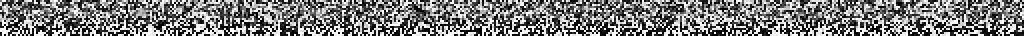

In [3]:
#Display a learned representations
np.set_printoptions(threshold=np.inf)
latentplot  = donald_trump# .reshape((96,96))
latentplot_formatted = (latentplot * 255 / np.max(latentplot)).astype('uint8')
img = PIL.Image.fromarray(latentplot_formatted)
img.resize((1024,36))

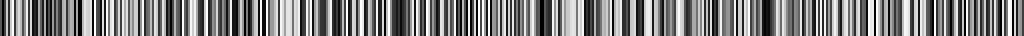

In [4]:
#Display a learned latent directions
np.set_printoptions(threshold=np.inf)
latentplot  = gender_direction# .reshape((96,96))
latentplot_formatted = (latentplot * 255 / np.max(latentplot)).astype('uint8')
img = PIL.Image.fromarray(latentplot_formatted)
img.resize((1024,36))

# Explore learned representations level mixing

In [5]:
def slider(x,y):
    image = draw_style_mixing_figure('fake', load_Gs(url_ffhq), w=1024, h=1024, src_seeds=[y[0],y[1]], dst_seeds=[y[0],y[1]], style_ranges=[range(x[0],x[1])]*2)
    display(image.resize((512,512)))
    return image



range_slider = widgets.IntRangeSlider(
                                        value=[3, 7],
                                        min=0,
                                        max=17,
                                        step=1,
                                        description='Level range:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d',
                                        layout=widgets.Layout(width='512px')
                                    )
seed_slider = widgets.IntRangeSlider(
                                        value=[0, 1000],
                                        min=0,
                                        max=1000,
                                        step=1,
                                        description='seeds:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d',
                                        layout=widgets.Layout(width='900px')
                                    )


w = interactive(slider, x =  range_slider, y=seed_slider );

display(w)



interactive(children=(IntRangeSlider(value=(3, 7), continuous_update=False, description='Level range:', layout…

# Explore dLatent space

Set the value of a single element  

In [7]:
def slider(value,element,level):
    latents = np.zeros((1,18,512))
    latents[0] = donald_trump   #Comment this line to use the "average face"
    latents[0][level][element] = value
    image = draw_image_from_latents(latents,load_Gs(url_ffhq))
    display(image.resize((256,256)))
    return image.resize((256,256))


s_value = widgets.FloatSlider(
    value=0,
    min=-50,
    max=50.0,
    step=0.5,
    description='Value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px')
)
s_element = widgets.IntSlider(
    value=7,
    min=0,
    max=511,
    step=1,
    description='Element:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='900px')
)

s_level = widgets.IntSlider(
    value=7,
    min=0,
    max=17,
    step=1,
    description='Level:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='900px')
)

w = interactive(slider,value=s_value,element=s_element,level=s_level );

display(w)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Value:', layout=Layout(widt…

# Play with trained directions

In [8]:
def slider( gender,
            headPose_yaw,
            headPose_roll,
            age_kid,
            age_middle,
            age_young,
            age_old,
            glasses,
            smile,
            anger,
            sadness,
            contempt,
            fear,
            happiness,
            neutral,
            surprise,
            disgust,
            Makeup,
            facialhair,
            beard,
            moustache,
            sideburns
                   
          ):
    latents = donald_trump# np.zeros((18,512))
    new_latents = np.zeros((18,512))
    new_latents[:18] = latents[:18]
    new_latents[:8] = latents[:8] + (  gender*gender_direction
                                + headPose_yaw*headPose_yaw_direction
                                - headPose_roll*headPose_roll_direction
                                + Makeup*(eyeMakeup_direction - lipMakeup_direction)
                                - age_kid*age_kid_direction
                                + age_middle*age_middle_direction
                                - age_young*age_young_direction
                                + age_old*age_old_direction
                                + glasses*glasses_direction
                                + smile*smile_direction
                                + anger*anger_direction
                                + sadness*sadness_direction
                                + contempt*contempt_direction
                                + fear*fear_direction
                                + happiness*happiness_direction
                                + neutral*neutral_direction
                                + surprise*surprise_direction
                                + disgust*disgust_direction
                                + facialhair*facialhair_direction                    
                                + beard*beard_direction
                                + moustache*moustache_direction
                                + sideburns*sideburns_direction
                                    )[:8]
    
    image = draw_image_from_latents(new_latents,load_Gs(url_ffhq))
    display(image.resize((256,256)))
    return image  #


s_gender         =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='Gender:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)

s_headPose_yaw   =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='yaw:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_Makeup =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='Makeup:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_headPose_roll  =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='roll:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_age_kid        =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='age_kid:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_age_middle     =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='age_middle:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_age_young      =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='age_young:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_age_old        =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='age_old:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_glasses        =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='glasses:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_smile          =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='smile:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_anger          =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='anger:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_sadness        =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='sadness:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_contempt       =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='contempt:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)

s_fear           =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='fear:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_happiness      =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='happiness:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_neutral        =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='neutral:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_surprise       =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='surprise:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_disgust       =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='disgust:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_facialhair          =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='facialhair:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_beard          =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='beard:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_moustache          =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='moustache:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)
s_sideburns         =   widgets.FloatSlider(
    value=0,
    min=-3,
    max=3.0,
    step=0.1,
    description='sideburns:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='900px',height='10px')
)


w = interactive(slider,         gender = s_gender,
                                glasses = s_glasses,
                                headPose_yaw = s_headPose_yaw,
                                headPose_roll = s_headPose_roll,
                                age_kid = s_age_kid,
                                age_middle = s_age_middle,
                                age_young = s_age_young,
                                age_old = s_age_old,
                                smile = s_smile,
                                anger = s_anger,
                                sadness = s_sadness,
                                contempt = s_contempt,
                                fear = s_fear,
                                happiness = s_happiness,
                                neutral = s_neutral,
                                surprise = s_surprise,
                                disgust = s_disgust,
                                Makeup = s_Makeup,
                                facialhair = s_facialhair,  
                                beard = s_beard,                
                                moustache = s_moustache,               
                                sideburns = s_sideburns,                 
               );

display(w)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Gender:', layout=Layout(hei…